## Przykłady wykorzystania modułów

### Importy
Tutaj są wszystkie koniecze importy, ale pod instalację jest plik requirements.txt w głównym folderze projektu

In [2]:
from scraper.data_loader import DataLoader
import matplotlib.pyplot as plt
import cv2
import numpy as np
from grid_manager import GridManager
from skimage.morphology import skeletonize
from graph_remaker.morphological_remaker import discover_streets

from grid_manager import GRID_INDICES
from scraper.graph_loader import GraphLoader
from trainer.clipping_sequence import ClippingBatchSequence
from trainer.batch_sequence import BatchSequence

### Download mesh and get grid from OSM

In [17]:
from scraper.data_loader import DataLoader
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [18]:
# IMPORTANT!! - dataloader checks, if the file already exists

cityname = "Tychy"

loader = DataLoader(1)

grid_manager = loader.load_city_grid(cityname, cityname + ".dat")
# loader.add_elevation_to_grid(grid_manager)

Roads with 'width' attribute: 8395
Roads without 'width' attribute: 19145
Height: 10468, Width: 11702, rows: 3, cols: 3
Segment: 0, 0 -> Expected: 5000x5000, Got: 5000x5000, Saved: (5000, 5000, 2)
Segment: 0, 1 -> Expected: 5000x5000, Got: 5000x5000, Saved: (5000, 5000, 2)
Segment: 0, 2 -> Expected: 5000x1702, Got: 5000x1701, Saved: (5000, 1702, 2)
Segment: 1, 0 -> Expected: 5000x5000, Got: 5000x5000, Saved: (5000, 5000, 2)
Segment: 1, 1 -> Expected: 5000x5000, Got: 5000x5000, Saved: (5000, 5000, 2)
Segment: 1, 2 -> Expected: 5000x1702, Got: 5000x1701, Saved: (5000, 1702, 2)
Segment: 2, 0 -> Expected: 468x5000, Got: 467x5000, Saved: (468, 5000, 2)
Segment: 2, 1 -> Expected: 468x5000, Got: 467x5000, Saved: (468, 5000, 2)
Segment: 2, 2 -> Expected: 468x1702, Got: 467x1701, Saved: (468, 1702, 2)


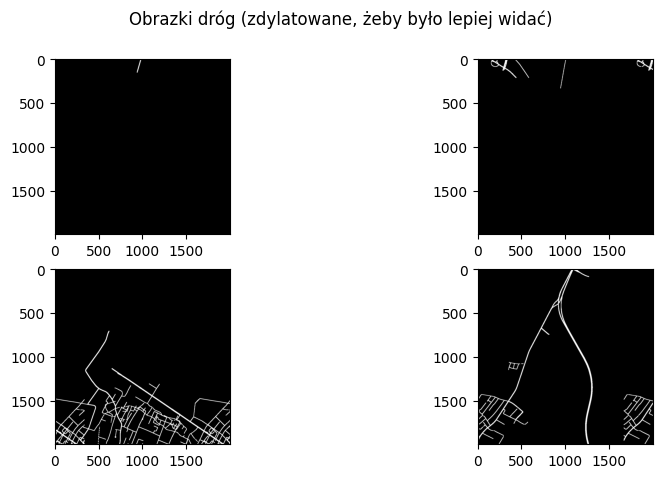

In [19]:
img = grid_manager.read_segment(1,1)[:2000, :2000, 0]

fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle("Obrazki dróg (zdylatowane, żeby było lepiej widać)")

imgs = [
    [grid_manager.read_segment(0,0)[3000:, 3000:, 0], grid_manager.read_segment(0,1)[3000:, :2000, 0]],
    [grid_manager.read_segment(1,0)[:2000, 3000:, 0], grid_manager.read_segment(1,1)[:2000, :2000, 0]]
]

dilated_imgs = []

struct_el = np.ones((3,3))

for imgs_row in imgs:
    target_row = []
    dilated_imgs.append(target_row)
    for img in imgs_row:
        target_row.append(cv2.dilate(img, struct_el, iterations=3))

plt.gray()
axs[0,0].imshow(dilated_imgs[0][0])
axs[0,1].imshow(dilated_imgs[0][1])
axs[1,0].imshow(dilated_imgs[1][0])
axs[1,1].imshow(dilated_imgs[1][1])

### Data management

In [1]:
from grid_manager import GridManager
import numpy as np

filename = "przyklad1.dat"

src_man = GridManager(filename, 2000, 2000, 0.0, 0.0, 1, 3, 3)

# a = np.zeros((2000, 2000, 2), dtype=np.float64)
is_street = np.array([
    [1, 2, 3, 4, 5, 6],
    [11, 12, 13, 14, 15, 16],
    [21, 22, 23, 24, 25, 26],
    [31, 32, 33, 34, 35, 36],
    [41, 42, 43, 44, 45, 46],
    [51, 52, 53, 54, 55, 56],
])
a = np.zeros((is_street.shape[0], is_street.shape[1], 3))
a[:,:, 0] = is_street

for x in range(2):
    for y in range(2):
        src_man.write_segment(a[y * 3: (y + 1) * 3, x*3:(x + 1) * 3], y, x)


src_man.write_segment(a[:2,:3, :] + 1, 666, 0)
src_man.write_segment(a[:3,:2, :] + 2, 0, 666)

man = src_man.deep_copy()

print(f"1: {man.read_segment(0, 0)[:, :, 0]}")
print(f"2: {man.read_segment(0, 1)[:, :, 0]}")
print(f"3: {man.read_segment(1, 0)[:, :, 0]}")
print(f"4: {man.read_segment(1, 1)[:, :, 0]}")
print(f"5: {man.read_segment(666, 666)[:, :, 0]}")

print(man.get_metadata())

man.delete()


1: [[ 1.  2.  3.]
 [11. 12. 13.]
 [21. 22. 23.]]
2: [[ 4.  5.  6.]
 [14. 15. 16.]
 [24. 25. 26.]]
3: [[31. 32. 33.]
 [41. 42. 43.]
 [51. 52. 53.]]
4: [[34. 35. 36.]
 [44. 45. 46.]
 [54. 55. 56.]]
5: [[0. 0.]
 [0. 0.]]
GridFileMetadata(version=1, rows_number=2000, columns_number=2000, upper_left_longitude=0.0, upper_left_latitude=0.0, grid_density=1.0, segment_h=3, segment_w=3, byteorder='little', third_dimension_size=3, metadata_bytes=35)


### Streets discovery

In [2]:
import matplotlib.pyplot as plt

def show_crossroads(img_height, img_width, conflictless_crossroads, conflicting_crossroads):
    fig, axs = plt.subplots(  max(2, len(conflictless_crossroads), len(conflicting_crossroads)), 6, figsize=(10,5))
    axs[0, 0].set_title("conflictless")
    axs[0, 1].set_title("junctions")
    axs[0, 2].set_title("conflicts")
    axs[0, 3].set_title("conflicting")
    axs[0, 4].set_title("junctions")
    axs[0, 5].set_title("conflicts")


    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.points:
            crossroad_image[point] = 1

        axs[i, 0].imshow(crossroad_image)

    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for street in crossroad.street_junctions.keys():
            crossroad_image[crossroad.street_junctions[street]] = 1

        axs[i, 1].imshow(crossroad_image)

    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.conflicting_points:
            crossroad_image[point] = 1

        axs[i, 2].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.points:
            crossroad_image[point] = 1

        axs[i, 3].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for street in crossroad.street_junctions.keys():
            crossroad_image[crossroad.street_junctions[street]] = 1

        axs[i, 4].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.conflicting_points:
            crossroad_image[point] = 1

        axs[i, 5].imshow(crossroad_image)


In [3]:
import matplotlib.pyplot as plt

def show_streets(img_height, img_width, conflictless_streets, conflicting_streets):
    fig, axs = plt.subplots(  max(2, len(conflictless_streets), len(conflicting_streets)), 4, figsize=(10,8))
    axs[0, 0].set_title("conflictless")
    axs[0, 1].set_title("conflicts")
    axs[0, 2].set_title("conflicting")
    axs[0, 3].set_title("conflicts")


    for i in range(len(conflictless_streets)):
        street = conflictless_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.linestring:
            street_image[point] = 1

        axs[i, 0].imshow(street_image)
    
    for i in range(len(conflictless_streets)):
        street = conflictless_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.conflicts:
            street_image[point] = 1

        axs[i, 1].imshow(street_image)

    for i in range(len(conflicting_streets)):
        street = conflicting_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.linestring:
            street_image[point] = 1

        axs[i, 2].imshow(street_image)
    
    for i in range(len(conflicting_streets)):
        street = conflicting_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.conflicts:
            street_image[point] = 1

        axs[i, 3].imshow(street_image)


#### Diamond

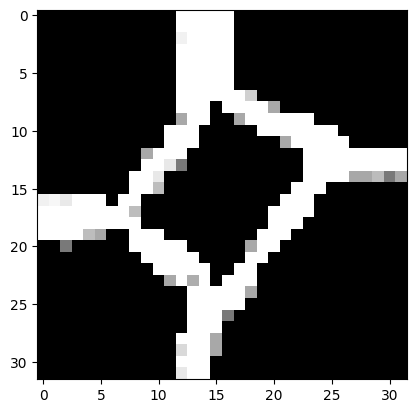

In [4]:
import numpy as np
from skimage.morphology import skeletonize
from graph_remaker.morphological_remaker import discover_streets
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("test_images/diamond.png", cv2.IMREAD_GRAYSCALE)
plt.gray()
bin_image = image > 0
# plt.imshow(bin_image * 255)

processed_image = bin_image[:, :, np.newaxis]
processed_image = np.concatenate((processed_image, np.zeros(processed_image.shape)), axis=2)

conflictless_crossroads, conflicting_crossroads, conflictless_streets, conflicting_streets = discover_streets(processed_image)

height, width = image.shape
plt.imshow(image)

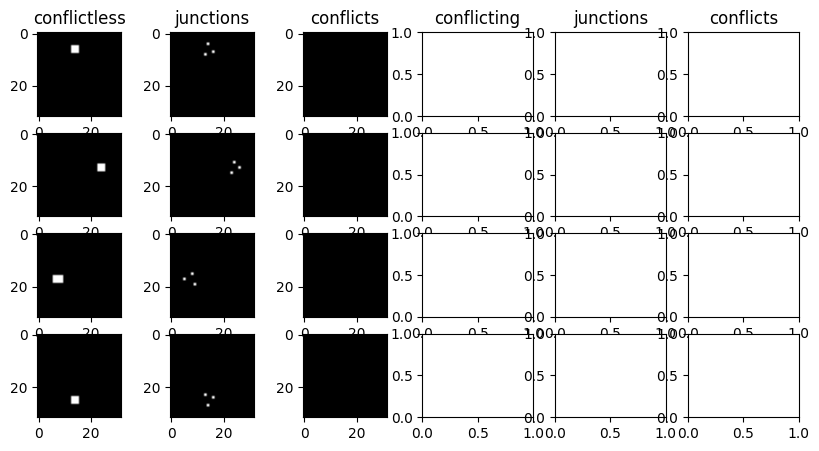

In [5]:
show_crossroads(height, width, conflictless_crossroads, conflicting_crossroads)

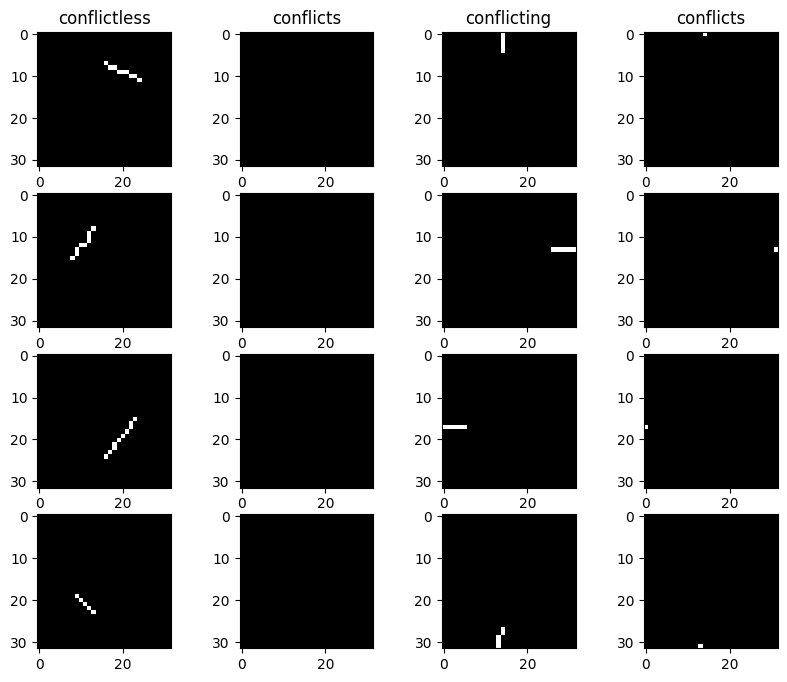

In [8]:
show_streets(height, width, conflictless_streets, conflicting_streets)

#### Conflicting crossroad and dead-end

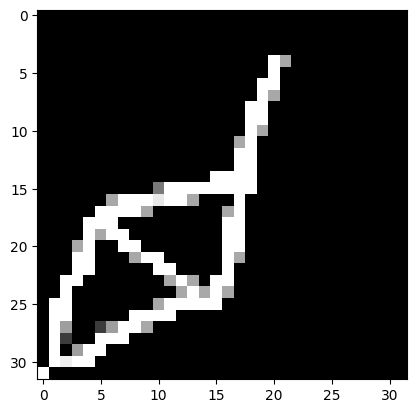

In [6]:
import numpy as np
from skimage.morphology import skeletonize
from graph_remaker.morphological_remaker import discover_streets
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("test_images/crossroad_conflict_deadend.png", cv2.IMREAD_GRAYSCALE)
plt.gray()
bin_image = image > 0
# plt.imshow(bin_image * 255)

processed_image = bin_image[:, :, np.newaxis]
processed_image = np.concatenate((processed_image, np.zeros(processed_image.shape)), axis=2)

conflictless_crossroads, conflicting_crossroads, conflictless_streets, conflicting_streets = discover_streets(processed_image)

height, width = image.shape
plt.imshow(image)

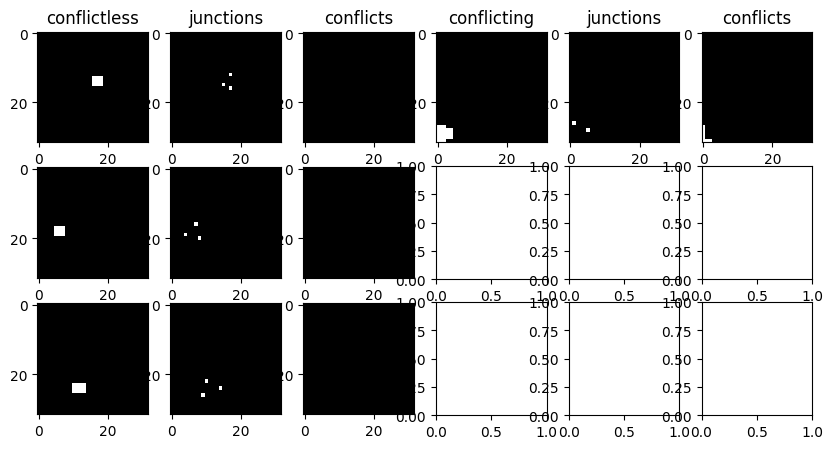

In [7]:
show_crossroads(width, height, conflictless_crossroads, conflicting_crossroads)

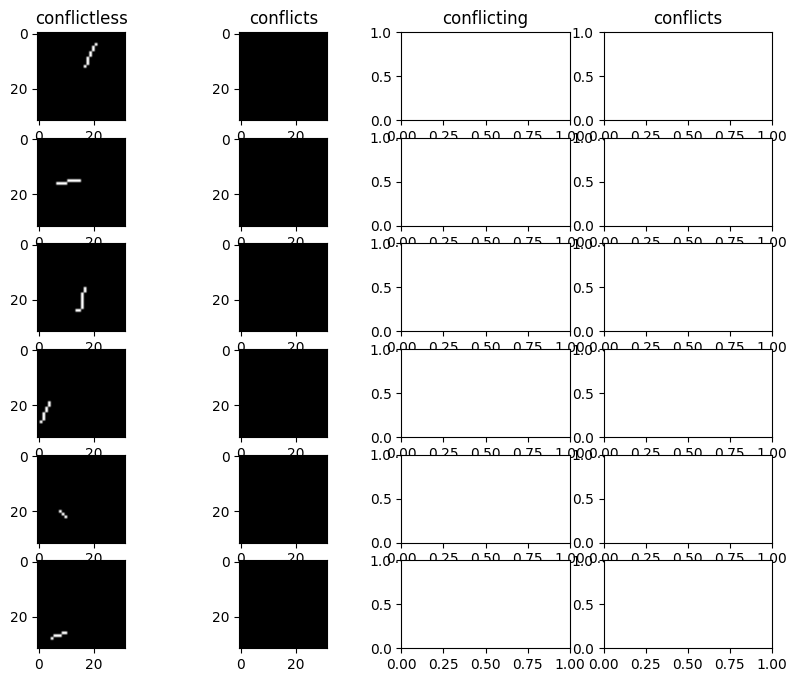

In [5]:
show_streets(width, height, conflictless_streets, conflicting_streets)

### Model training

In [3]:
from scraper.grid_builder import GridBuilder
from grid_manager import GRID_INDICES
import numpy as np
from scraper.graph_loader import GraphLoader
from scraper.geometry_processor import GeometryProcessor

import cv2
from grid_manager import GridManager
from trainer.clipping_sequence import ClippingBatchSequence
from trainer.batch_sequence import BatchSequence

przyklad = cv2.imread("test_images/przyklad_Grzegorza2.png", cv2.IMREAD_GRAYSCALE)
przyklad = przyklad > 0
processed_image = przyklad[:, :, np.newaxis]
processed_image = np.concatenate((processed_image, np.zeros(processed_image.shape)), axis=2)

man = GridManager("przyklad1.dat", 2160, 3840, 0.0, 0.0, 1, 2160, 3840)
man.write_segment(processed_image, 0, 0)



batchSeq = ClippingBatchSequence(
            BatchSequence(
                files=list(["przyklad1.dat"]),
                batch_size=1,
                cut_sizes=[(256, 256)],
            ),
            clipping_size=256,
            input_grid_surplus=32,
        )

X, Y = batchSeq[0]
print(X.shape)
print(Y.shape)

Cut size: (256, 256), Max start points: x=3584, y=1904
Requested cut at (904, 354) of size (256, 256) with surplus 0, clipping=False
Cut from segments: start_x=904, start_y=354, end_x=1160, end_y=610
Segment size: w=3840, h=2160
Segments to read: start_x=0, start_y=0, end_x=0, end_y=0
Reading segment at (0, 0) with shape (2160, 3840, 3)
Clipping index: 0 -> 0 0
Requested cut at (0, 0) of size (256, 256) with surplus 32, clipping=True
Cut from segments: start_x=0, start_y=0, end_x=256, end_y=256
Segment size: w=3840, h=2160
Segments to read: start_x=0, start_y=0, end_x=0, end_y=0
Reading segment at (0, 0) with shape (256, 256, 3)
(1, 256, 256, 3)
(1, 224, 224, 2)
